# Results of simulation of different fairness policies

These experiments use accumulated deficits to try to ensure that applications always receive their computed allocation of GPU time, even in the event of new jobs coming in and old jobs finishing, by keeping track of the difference between the GPU time the application should have received, and the GPU time the application actually received. Allocation of jobs to GPUs is performed in a round-based fashion, with GPUs instructed to run jobs for a fixed interval of time on all GPUs.

# Import statements

In [1]:
from matplotlib import pyplot as plt
import matplotlib; matplotlib.font_manager._rebuild()
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=2, rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
# Other imports.
import os
import re

# Get logfile paths

In [3]:
def get_logfile_paths_helper(directory_name):
    logfile_paths = []
    for root, _, file_names in os.walk(directory_name):
        if len(file_names) > 0:
            logfile_paths.extend(
                [os.path.join(root, file_name)
                 for file_name in file_names])
    return logfile_paths

def get_logfile_paths(directory_name):
    logfile_paths = []
    for logfile_path in get_logfile_paths_helper(directory_name):
        m = re.match(
            r'.*v100=(\d+)\.p100=(\d+)\.k80=(\d+)/(.*)/seed=(\d+)/'
             'lambda=(\d+\.\d+)\.log', logfile_path)
        if m is None: continue
        v100s = int(m.group(1))
        p100s = int(m.group(2))
        k80s = int(m.group(3))
        policy = m.group(4)
        seed = int(m.group(5))
        l = float(m.group(6))
        logfile_paths.append((v100s, p100s, k80s, policy, seed,
                              l, logfile_path))
    return logfile_paths

In [4]:
labels = {"allox": "AlloX",
          "gandiva": "LAS w/ Gandiva SS",
          "fifo": "FIFO",
          "fifo_perf": "Gavel",
          "fifo_packed": "Gavel w/ SS",
          "finish_time_fairness": "FTF",
          "finish_time_fairness_perf": "Gavel",
          "max_min_fairness": "LAS",
          "max_min_fairness_perf": "Gavel",
          "max_min_fairness_packed": "Gavel w/ SS"}

# Plotting functions

In [5]:
def prune(logfile_paths, v100s, p100s, k80s, policy, seed=None):
    if seed is None:
        return sorted([(x[5], x[6], x[4]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy])
    else:
        return sorted([(x[5], x[6]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and
                       x[4] == seed])

In [6]:
def plot_metric_vs_inverse_lambda(v100s, p100s, k80s,
                                  policies, metric_fn,
                                  metric_label,
                                  xmax=None,
                                  ymax=None,
                                  output_filename=None,
                                  extrapolate=False):
    plt.figure(figsize=(10, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    data = {"input_job_rate": [], "metric": [], "seed": [],
            "policy": []}
    print(policies)
    for policy in policies:
        relevant_logfile_paths = list(reversed(prune(
            logfile_paths, v100s, p100s, k80s, policy)))
        lambdas = [x[0] for x in relevant_logfile_paths]
        input_job_rates = [3600.0 / x for x in lambdas]
        metrics = [metric_fn(x[1]) for x in relevant_logfile_paths]
        seeds = [x[2] for x in relevant_logfile_paths]
        policies = [labels[policy] for i in range(len(metrics))]

        data["input_job_rate"] += input_job_rates
        data["metric"] += metrics
        data["seed"] += seeds
        data["policy"] += policies
        if len(input_job_rates) > 0 and extrapolate:
            data["input_job_rate"] += [max(input_job_rates) + 0.4]
            data["metric"] += [105.0]
            data["seed"] += [0]
            data["policy"] += [labels[policy]]
    import pandas as pd
    df = pd.DataFrame(data)
    grouped_df = df.groupby(["policy", "input_job_rate"])
    for name_of_the_group, group in grouped_df:
        print(name_of_the_group)
        print(group.mean())

    sns.lineplot(x='input_job_rate', y='metric', style='policy',
                 hue='policy',
                 data=data, ci='sd',
                 markers=True)

    ax.set_xlabel("Input job rate (jobs/hr)")
    ax.set_ylabel(metric_label)
    ax.set_xlim([0, xmax])
    ax.set_ylim([0, ymax])
    sns.despine()
    
    leg = plt.legend(loc='upper left', frameon=False)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    bb.y0 += 0.22
    bb.y1 += 0.22
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

In [7]:
import random
import sys; sys.path.append("../../..")
from job_table import JobTable

def get_job_durations(seed, generate_multigpu_jobs):
    job_generator = random.Random()
    job_generator.seed(seed+2)
    
    job_durations = []
    for i in range(5000):
        r = job_generator.uniform(0, 1)
        scale_factor = 1
        if 0.7 <= r <= 0.8:
            scale_factor = 2
        elif 0.8 <= r <= 0.95:
            scale_factor = 4
        elif 0.95 <= r:
            scale_factor = 8
        if not generate_multigpu_jobs:
            scale_factor = 1
        if job_generator.random() >= 0.8:
            job_duration = 60 * (10 ** job_generator.uniform(3, 4))
        else:
            job_duration = 60 * (10 ** job_generator.uniform(1.5, 3))

        while True:
            job_template = job_generator.choice(JobTable)
            if (scale_factor == 1 or
                (scale_factor > 1 and job_template.distributed)):
                break
                
        job_durations.append((job_duration, job_template))
    return job_durations

In [8]:
def get_jcts(logfile_path, seed, min_job_id=None, max_job_id=None):
    job_completion_times = []
    job_durations = get_job_durations(seed, generate_multigpu_jobs=False)
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Job (\d+): (\d+\.\d+)', line)
            if m is not None:
                job_id = int(m.group(1))
                job_completion_time = float(m.group(2))
                if min_job_id is None or min_job_id <= job_id:
                    if max_job_id is None or job_id <= max_job_id:
                        job_duration, job_template = job_durations[job_id]
                        job_completion_times.append(
                            (job_completion_time, job_duration))
    return [(x[0] / 3600.0, x[1] / 3600.0) for x in job_completion_times]

In [9]:
def plot_jct_cdf(v100s, p100s, k80s,
                 max_input_job_rate,
                 policies,
                 min_job_id, max_job_id,
                 finish_time_fairness=False,
                 output_directory=None):
    
    lambdas = list(set([x[5] for x in logfile_paths]))
    lambdas.sort(reverse=True)
    print(policies)

    for l in lambdas:
        handles_in_legend = []
        labels_in_legend = []
        
        input_job_rate = 3600.0 / l
        if input_job_rate > max_input_job_rate:
            continue
        print("Input job rate: %.2f" % input_job_rate)
        
        plt.figure(figsize=(10, 3))
        axes = [
            plt.subplot2grid((1, 2), (0, 0), rowspan=1),
            plt.subplot2grid((1, 2), (0, 1), rowspan=1),
        ]
        titles = ["Short jobs", "Long jobs"]

        if finish_time_fairness:
            relevant_logfile_paths = list(reversed(prune(
                logfile_paths, v100s, p100s, k80s, "isolated", seed=0)))
            relevant_logfile_paths = [x for x in relevant_logfile_paths
                                      if x[0] == l]
            if len(relevant_logfile_paths) != 1:
                continue
            isolated_jcts = get_jcts(relevant_logfile_paths[0][1],
                                     seed=0,
                                     min_job_id=min_job_id,
                                     max_job_id=max_job_id)
            isolated_jcts.sort(key=lambda x: x[1])
        linestyles = ['--', '-.', ':', '--', '-.']
        for i, policy in enumerate(policies):
            relevant_logfile_paths = list(reversed(prune(
                logfile_paths, v100s, p100s, k80s, policy, seed=0)))
            relevant_logfile_paths = [x for x in relevant_logfile_paths
                                      if x[0] == l]
            if len(relevant_logfile_paths) != 1:
                continue
            jcts = get_jcts(relevant_logfile_paths[0][1],
                            seed=0,
                            min_job_id=min_job_id,
                            max_job_id=max_job_id)
            jcts.sort(key=lambda x: x[1])
            if finish_time_fairness:
                jcts = [x[0] / y[0] for (x, y) in zip(jcts, isolated_jcts)]
            else:
                jcts = [x[0] for x in jcts]
                
            print("%s: %.2f" % (policy, np.mean(jcts)))
            partition_point = int(len(jcts) * 0.8)
            jcts = np.split(np.array(jcts), [partition_point])
            for j, (ax, jcts_segment) in enumerate(zip(axes, jcts)):
                jcts_segment.sort()
                percentiles = [(i+1) / len(jcts_segment)
                               for i in range(len(jcts_segment))]

                if "Gavel" in labels[policy]:
                    handle = ax.plot(jcts_segment, percentiles,
                                     color=current_palette[i],
                                     linestyle='-',
                                     linewidth=3)
                else:
                    handle = ax.plot(jcts_segment, percentiles,
                                     color=current_palette[i],
                                     linestyle=linestyles[i])
                if j == 0:
                    handles_in_legend.append(handle[0])
                    labels_in_legend.append(labels[policy])

        for i, (ax, title) in enumerate(zip(axes, titles)):
            if finish_time_fairness:
                ax.set_xlabel("FTF" + "\n" + title)
                ax.set_xlim([0, 4])
                ax.set_xticks([0, 1, 2, 3, 4])
            else:
                ax.set_xlabel("JCT (hrs, log2)" + "\n" + title)
                ax.set_xscale('log', basex=2)
                ax.xaxis.set_major_locator(plt.LogLocator(base=2, numticks=4))
            if i == 0:
                ax.set_ylabel("Fraction of jobs")
            ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            if i > 0:
                ax.set_yticklabels(["", "", "", "", "", ""])
            ax.set_ylim([0, 1.0])
        sns.despine()
    
        leg = plt.figlegend(handles=handles_in_legend,
                            labels=labels_in_legend,
                            ncol=3, frameon=False,
                            loc='upper center')
        bb = leg.get_bbox_to_anchor().inverse_transformed(
            axes[1].transAxes)
        bb.y0 += 0.22
        bb.y1 += 0.22
        leg.set_bbox_to_anchor(bb, transform=axes[1].transAxes)
        
        if output_directory is not None:
            output_filename = os.path.join(output_directory,
                                           "input_job_rate=%d.pdf" % (input_job_rate * 10))
            with PdfPages(output_filename) as pdf:
                pdf.savefig(bbox_inches='tight')
        
        plt.show()

# Plot average JCT versus input job rate

In [10]:
def average_jct_fn(logfile_path, min_job_id=None, max_job_id=None):
    job_completion_times = []
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Job (\d+): (\d+\.\d+)', line)
            if m is not None:
                job_id = int(m.group(1))
                job_completion_time = float(m.group(2))
                if min_job_id is None or min_job_id <= job_id:
                    if max_job_id is None or job_id <= max_job_id:
                        job_completion_times.append(
                            job_completion_time)
    if len(job_completion_times) == 0:
        return None
    return np.mean(job_completion_times) / 3600

In [11]:
logfile_paths = sorted(get_logfile_paths(
    "/lfs/1/deepak/gpusched/scheduler/logs/single_gpu_continuous_jobs_final/"))

['fifo', 'fifo_perf', 'fifo_packed']
('FIFO', 0.4)
input_job_rate     0.400000
metric            17.371346
seed               1.000000
dtype: float64
('FIFO', 0.8)
input_job_rate     0.800000
metric            17.437143
seed               1.000000
dtype: float64
('FIFO', 1.2)
input_job_rate     1.200000
metric            17.482193
seed               1.000000
dtype: float64
('FIFO', 1.6)
input_job_rate     1.600000
metric            17.533384
seed               1.000000
dtype: float64
('FIFO', 2.0)
input_job_rate     2.000000
metric            17.985771
seed               1.000000
dtype: float64
('FIFO', 2.4)
input_job_rate     2.400000
metric            18.073415
seed               1.000000
dtype: float64
('FIFO', 2.799999999377778)
input_job_rate     2.800000
metric            18.174134
seed               1.000000
dtype: float64
('FIFO', 3.2)
input_job_rate     3.200000
metric            19.685843
seed               1.000000
dtype: float64
('FIFO', 3.6)
input_job_rate     3.600000
met

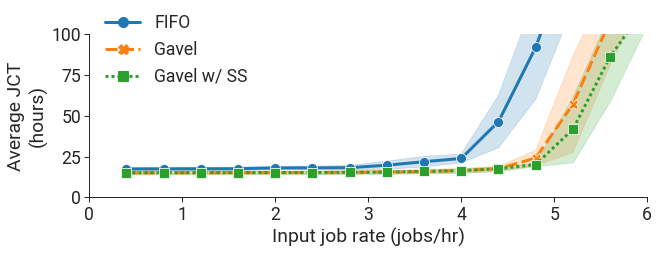

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva', 'allox']
('AlloX', 0.4)
input_job_rate     0.400000
metric            17.371346
seed               1.000000
dtype: float64
('AlloX', 0.8)
input_job_rate     0.800000
metric            17.437143
seed               1.000000
dtype: float64
('AlloX', 1.2)
input_job_rate     1.200000
metric            17.470776
seed               1.000000
dtype: float64
('AlloX', 1.6)
input_job_rate     1.600000
metric            17.370219
seed               1.000000
dtype: float64
('AlloX', 2.0)
input_job_rate     2.000000
metric            16.956415
seed               1.000000
dtype: float64
('AlloX', 2.4)
input_job_rate     2.400000
metric            16.387573
seed               1.000000
dtype: float64
('AlloX', 2.799999999377778)
input_job_rate     2.800000
metric            16.030998
seed               1.000000
dtype: float64
('AlloX', 3.2)
input_job_rate     3.200000
metric            16.028491
seed               1.000

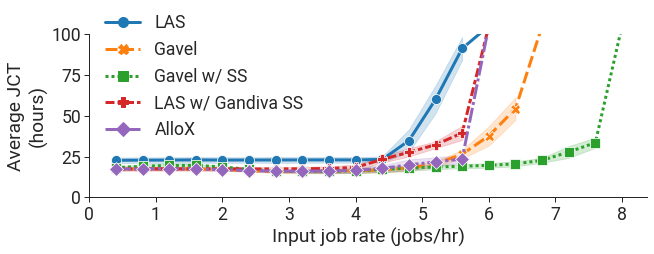

['finish_time_fairness', 'finish_time_fairness_perf', 'allox']
('AlloX', 0.4)
input_job_rate     0.400000
metric            17.371346
seed               1.000000
dtype: float64
('AlloX', 0.8)
input_job_rate     0.800000
metric            17.437143
seed               1.000000
dtype: float64
('AlloX', 1.2)
input_job_rate     1.200000
metric            17.470776
seed               1.000000
dtype: float64
('AlloX', 1.6)
input_job_rate     1.600000
metric            17.370219
seed               1.000000
dtype: float64
('AlloX', 2.0)
input_job_rate     2.000000
metric            16.956415
seed               1.000000
dtype: float64
('AlloX', 2.4)
input_job_rate     2.400000
metric            16.387573
seed               1.000000
dtype: float64
('AlloX', 2.799999999377778)
input_job_rate     2.800000
metric            16.030998
seed               1.000000
dtype: float64
('AlloX', 3.2)
input_job_rate     3.200000
metric            16.028491
seed               1.000000
dtype: float64
('AlloX', 3

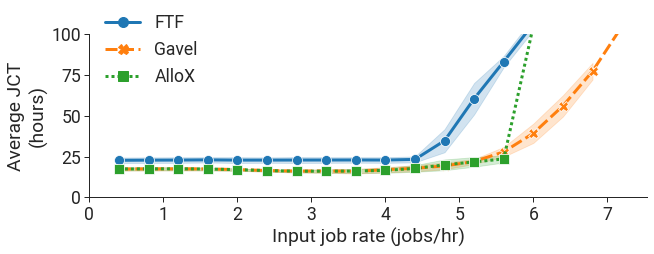

In [12]:
plot_metric_vs_inverse_lambda(
    v100s=36, p100s=36, k80s=36,
    policies=["fifo",
              "fifo_perf",
              "fifo_packed"],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    xmax=6.0,
    ymax=100.0,
    extrapolate=False,
    output_filename="continuous_jobs/single_gpu_fifo_v100=36_p100=36_k80=36.pdf"
)
plot_metric_vs_inverse_lambda(
    v100s=36, p100s=36, k80s=36,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva",
              "allox",],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=100.0,
    extrapolate=True,
    output_filename="continuous_jobs/single_gpu_las_v100=36_p100=36_k80=36.pdf"
)
plot_metric_vs_inverse_lambda(
    v100s=36, p100s=36, k80s=36,
    policies=["finish_time_fairness",
              "finish_time_fairness_perf",
              "allox"],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=100.0,
    extrapolate=True,
    output_filename="continuous_jobs/single_gpu_ftf_v100=36_p100=36_k80=36.pdf"
)

['fifo', 'fifo_perf', 'fifo_packed']
Input job rate: 0.40
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
fifo: 17.58
fifo_perf: 15.31
fifo_packed: 15.31


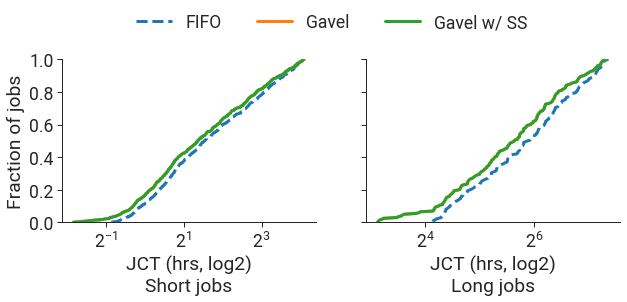

Input job rate: 0.80
fifo: 17.64
fifo_perf: 15.38
fifo_packed: 15.38


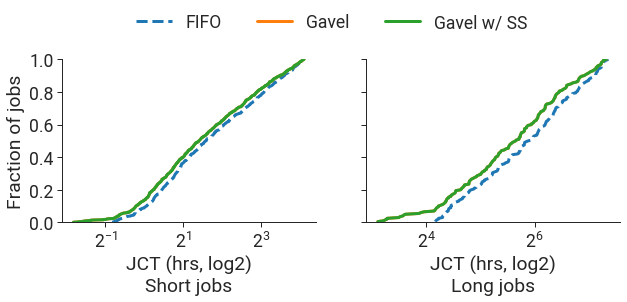

Input job rate: 1.20
fifo: 17.70
fifo_perf: 15.42
fifo_packed: 15.42


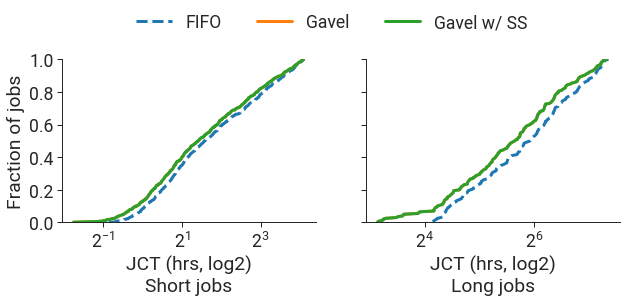

Input job rate: 1.60
fifo: 17.71
fifo_perf: 15.43
fifo_packed: 15.43


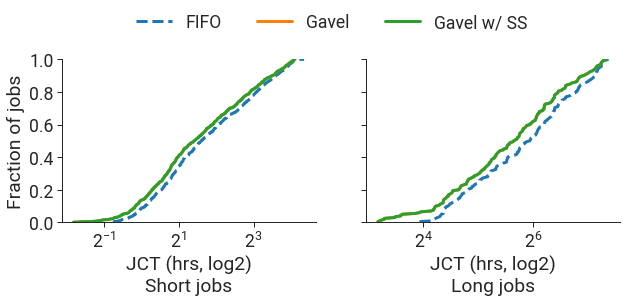

Input job rate: 2.00
fifo: 18.32
fifo_perf: 15.45
fifo_packed: 15.45


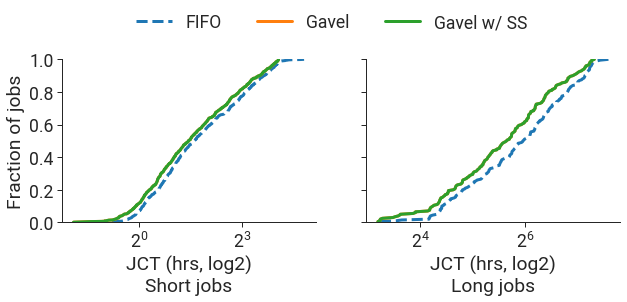

Input job rate: 2.40
fifo: 18.63
fifo_perf: 15.52
fifo_packed: 15.52


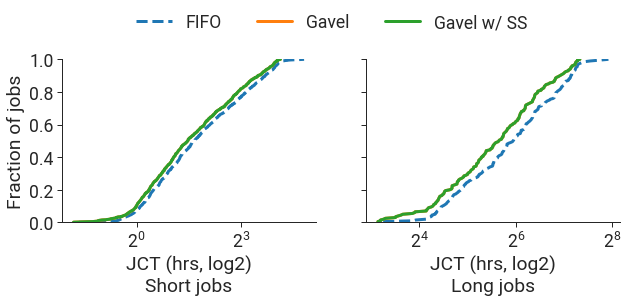

Input job rate: 2.80
fifo: 18.62
fifo_perf: 15.68
fifo_packed: 15.68


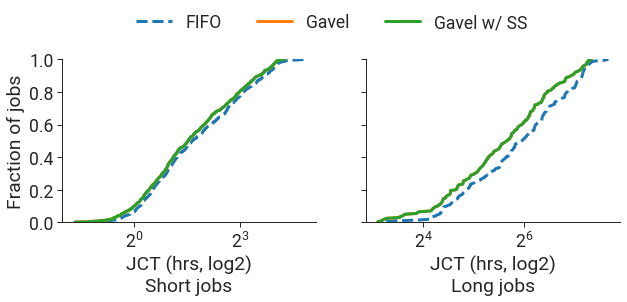

Input job rate: 3.20
fifo: 22.21
fifo_perf: 15.95
fifo_packed: 15.95


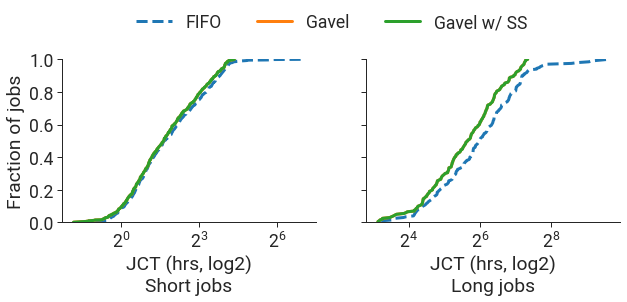

Input job rate: 3.60
fifo: 24.25
fifo_perf: 16.39
fifo_packed: 16.39


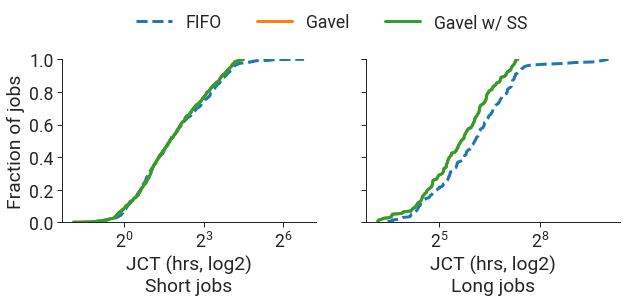

Input job rate: 4.00
fifo: 25.38
fifo_perf: 17.08
fifo_packed: 17.08


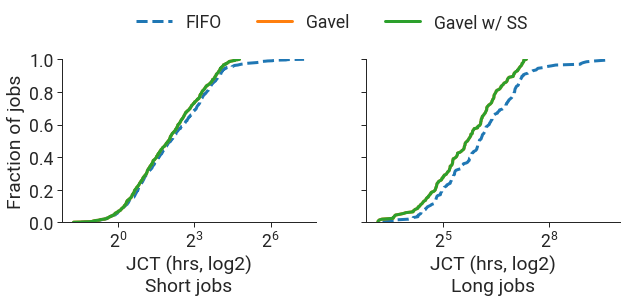

Input job rate: 4.40
fifo: 44.28
fifo_perf: 18.19
fifo_packed: 18.18


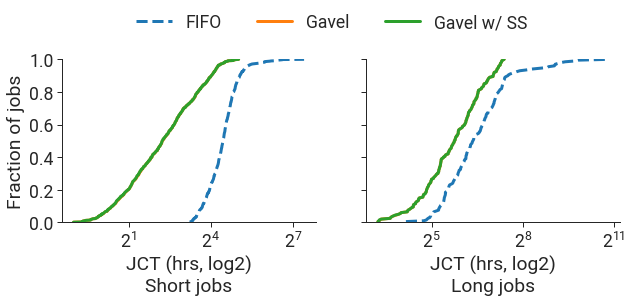

Input job rate: 4.80
fifo: 99.19
fifo_perf: 22.24
fifo_packed: 21.14


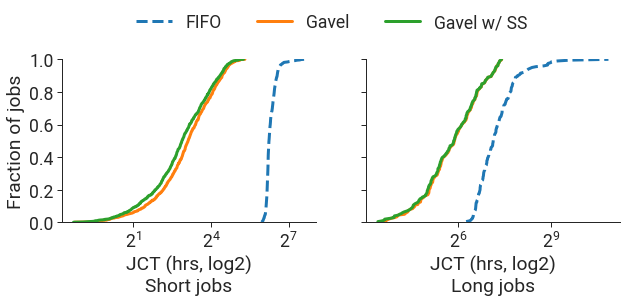

Input job rate: 5.20
fifo: 151.67
fifo_perf: 56.69
fifo_packed: 38.11


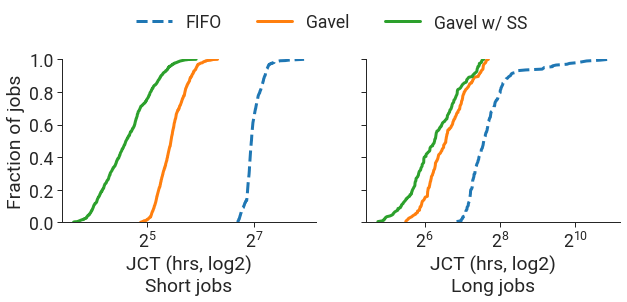

Input job rate: 5.60
fifo_perf: 104.12
fifo_packed: 83.40


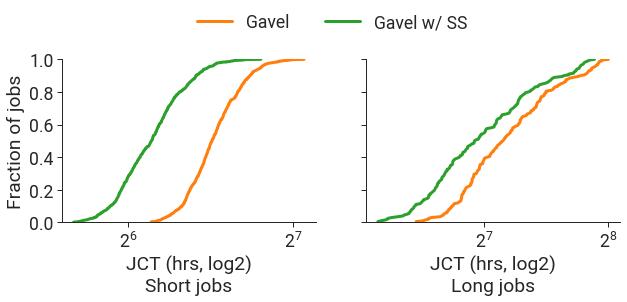

Input job rate: 6.00
fifo_perf: 150.04
fifo_packed: 127.10


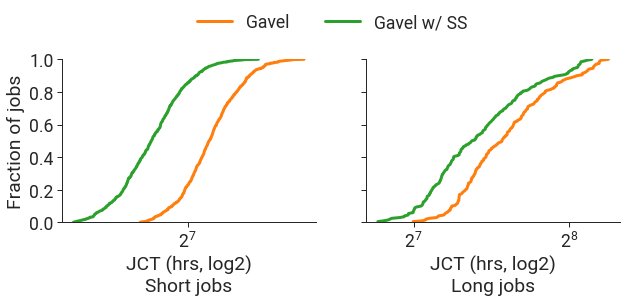

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva']
Input job rate: 0.40
max_min_fairness: 23.26
max_min_fairness_perf: 17.58
max_min_fairness_packed: 18.42
gandiva: 17.58


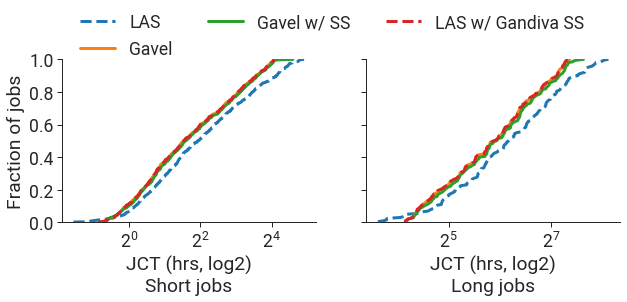

Input job rate: 0.80
max_min_fairness: 23.33
max_min_fairness_perf: 17.64
max_min_fairness_packed: 19.26
gandiva: 17.64


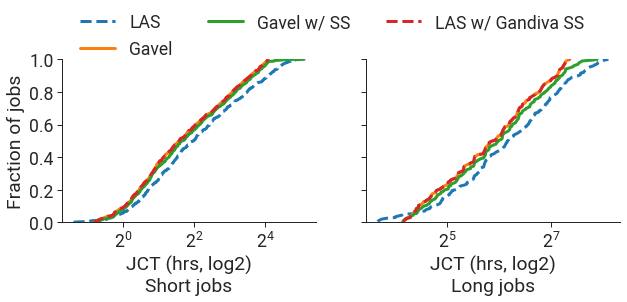

Input job rate: 1.20
max_min_fairness: 23.51
max_min_fairness_perf: 17.67
max_min_fairness_packed: 19.69
gandiva: 17.68


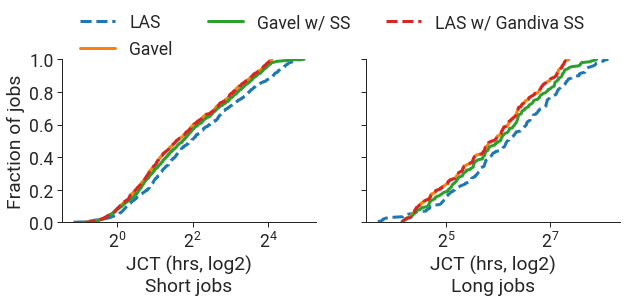

Input job rate: 1.60
max_min_fairness: 23.57
max_min_fairness_perf: 17.48
max_min_fairness_packed: 19.39
gandiva: 17.66


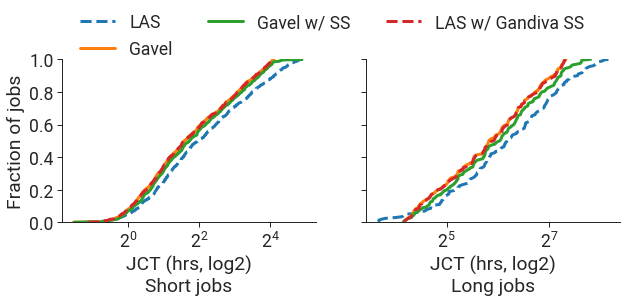

Input job rate: 2.00
max_min_fairness: 23.47
max_min_fairness_perf: 16.95
max_min_fairness_packed: 18.26
gandiva: 17.61


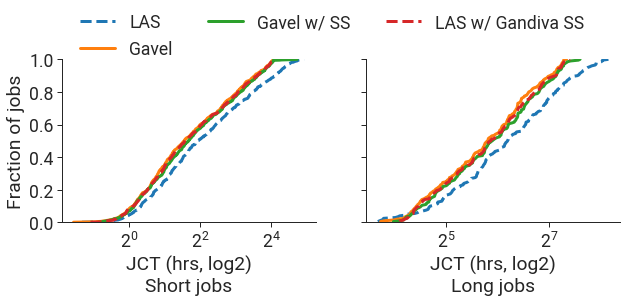

Input job rate: 2.40
max_min_fairness: 23.43
max_min_fairness_perf: 16.39
max_min_fairness_packed: 16.92
gandiva: 17.62


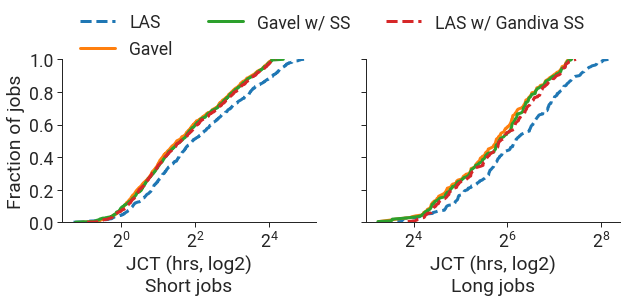

Input job rate: 2.80
max_min_fairness: 23.59
max_min_fairness_perf: 16.04
max_min_fairness_packed: 16.26
gandiva: 17.69


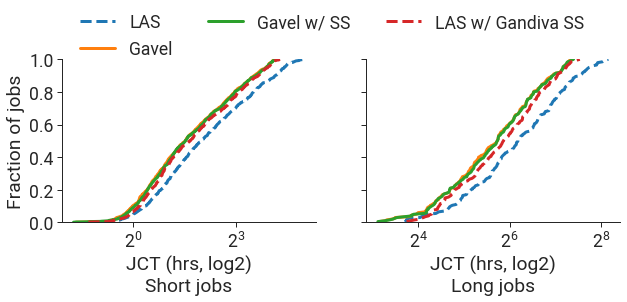

Input job rate: 3.20
max_min_fairness: 23.59
max_min_fairness_perf: 16.08
max_min_fairness_packed: 16.18
gandiva: 17.83


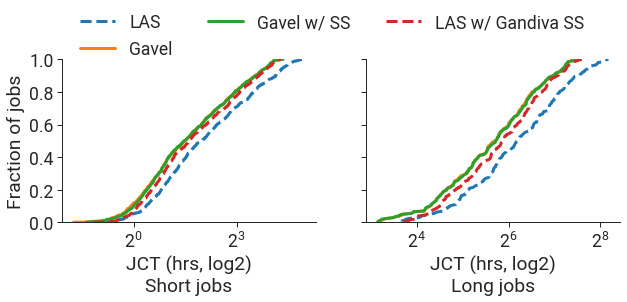

Input job rate: 3.60
max_min_fairness: 23.57
max_min_fairness_perf: 16.38
max_min_fairness_packed: 16.50
gandiva: 18.14


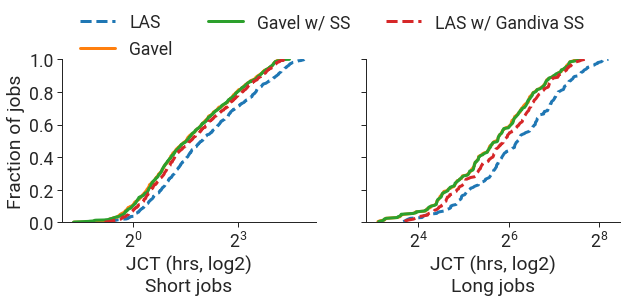

Input job rate: 4.00
max_min_fairness: 23.49
max_min_fairness_perf: 16.82
max_min_fairness_packed: 16.96
gandiva: 18.88


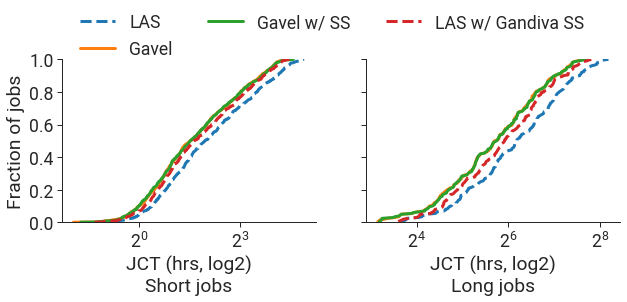

Input job rate: 4.40
max_min_fairness: 23.81
max_min_fairness_perf: 17.48
max_min_fairness_packed: 17.78
gandiva: 25.65


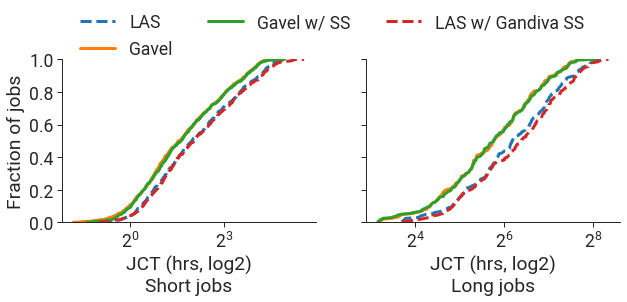

Input job rate: 4.80
max_min_fairness: 35.79
max_min_fairness_perf: 18.97
max_min_fairness_packed: 18.67
gandiva: 30.46


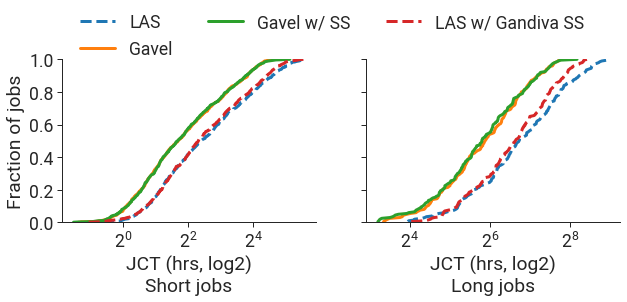

Input job rate: 5.20
max_min_fairness: 63.78
max_min_fairness_perf: 22.02
max_min_fairness_packed: 19.14
gandiva: 34.32


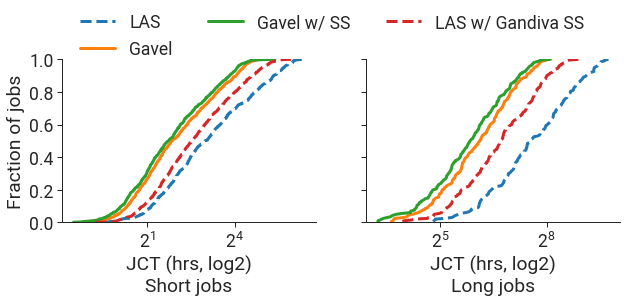

Input job rate: 5.60
max_min_fairness: 95.99
max_min_fairness_perf: 28.96
max_min_fairness_packed: 19.64
gandiva: 42.54


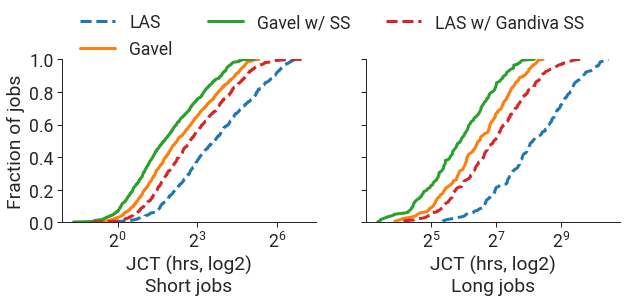

Input job rate: 6.00
max_min_fairness_perf: 41.23
max_min_fairness_packed: 20.42


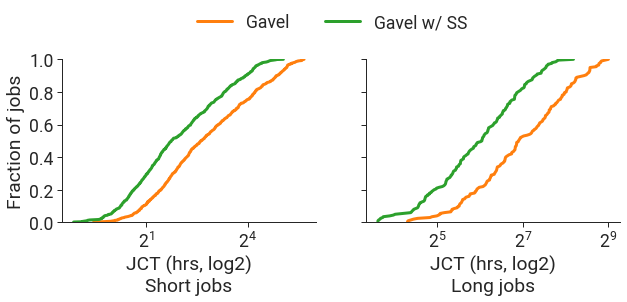

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva', 'allox']
Input job rate: 0.40
max_min_fairness: 23.26
max_min_fairness_perf: 17.58
max_min_fairness_packed: 18.42
gandiva: 17.58
allox: 17.58


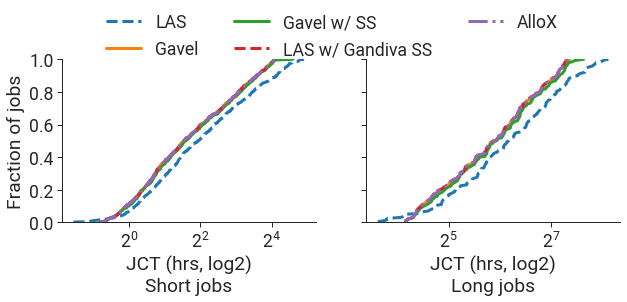

Input job rate: 0.80
max_min_fairness: 23.33
max_min_fairness_perf: 17.64
max_min_fairness_packed: 19.26
gandiva: 17.64
allox: 17.64


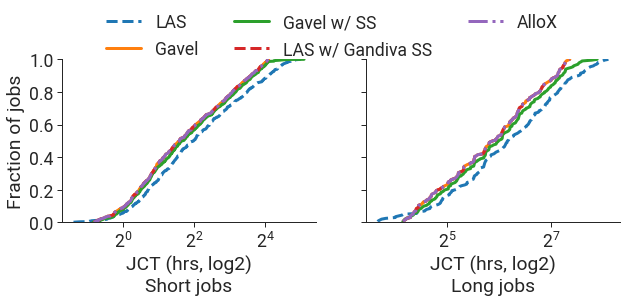

Input job rate: 1.20
max_min_fairness: 23.51
max_min_fairness_perf: 17.67
max_min_fairness_packed: 19.69
gandiva: 17.68
allox: 17.67


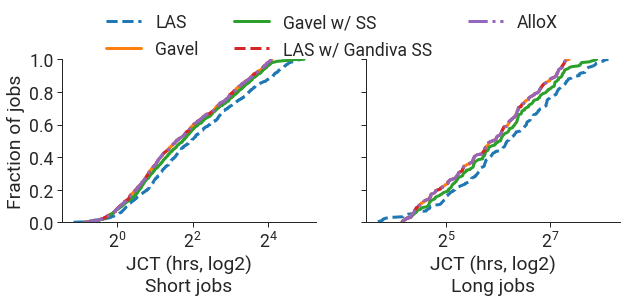

Input job rate: 1.60
max_min_fairness: 23.57
max_min_fairness_perf: 17.48
max_min_fairness_packed: 19.39
gandiva: 17.66
allox: 17.45


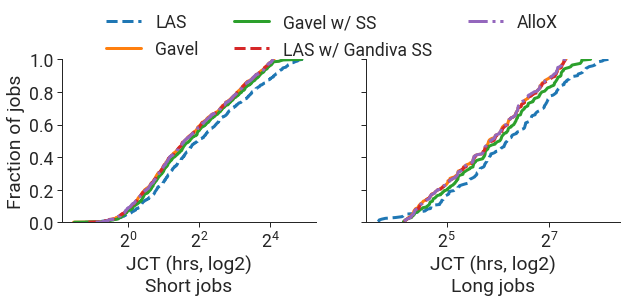

Input job rate: 2.00
max_min_fairness: 23.47
max_min_fairness_perf: 16.95
max_min_fairness_packed: 18.26
gandiva: 17.61
allox: 16.93


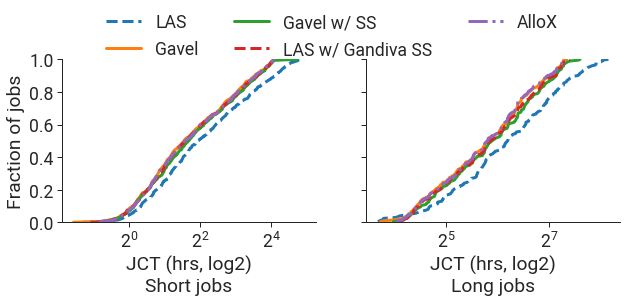

Input job rate: 2.40
max_min_fairness: 23.43
max_min_fairness_perf: 16.39
max_min_fairness_packed: 16.92
gandiva: 17.62
allox: 16.49


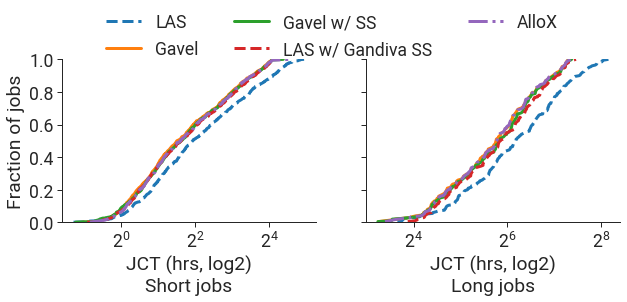

Input job rate: 2.80
max_min_fairness: 23.59
max_min_fairness_perf: 16.04
max_min_fairness_packed: 16.26
gandiva: 17.69
allox: 16.37


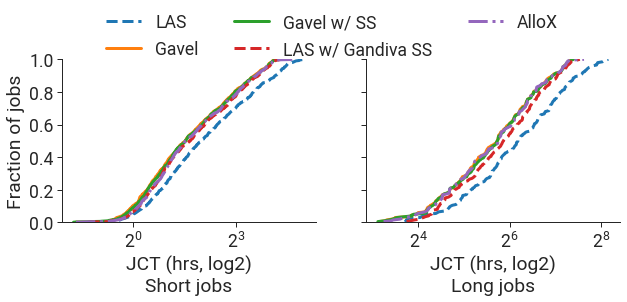

Input job rate: 3.20
max_min_fairness: 23.59
max_min_fairness_perf: 16.08
max_min_fairness_packed: 16.18
gandiva: 17.83
allox: 16.43


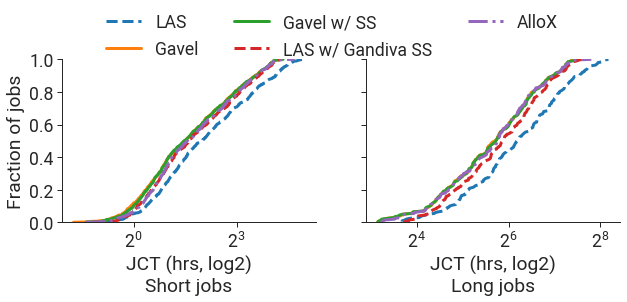

Input job rate: 3.60
max_min_fairness: 23.57
max_min_fairness_perf: 16.38
max_min_fairness_packed: 16.50
gandiva: 18.14
allox: 16.62


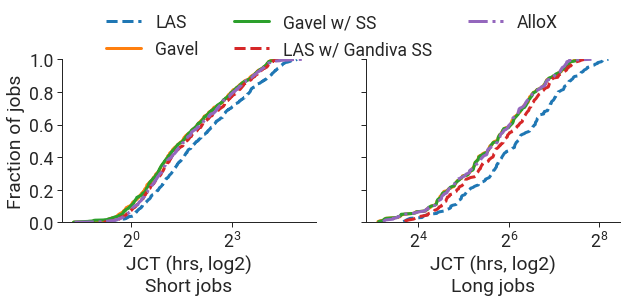

Input job rate: 4.00
max_min_fairness: 23.49
max_min_fairness_perf: 16.82
max_min_fairness_packed: 16.96
gandiva: 18.88
allox: 17.13


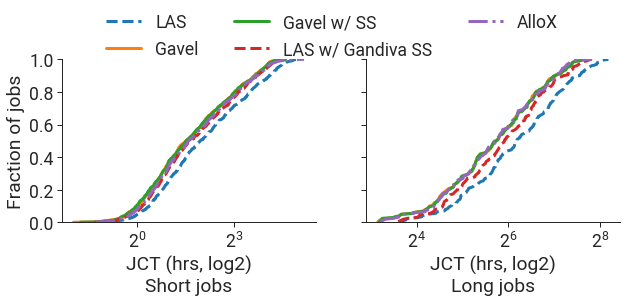

Input job rate: 4.40
max_min_fairness: 23.81
max_min_fairness_perf: 17.48
max_min_fairness_packed: 17.78
gandiva: 25.65
allox: 18.54


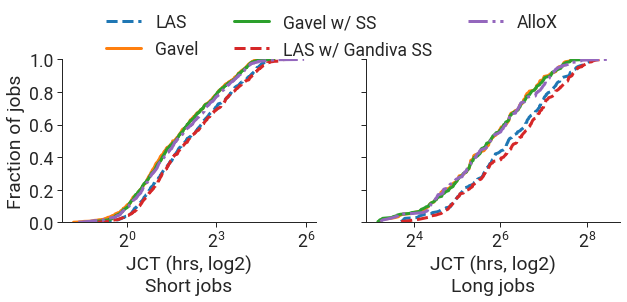

Input job rate: 4.80
max_min_fairness: 35.79
max_min_fairness_perf: 18.97
max_min_fairness_packed: 18.67
gandiva: 30.46
allox: 20.92


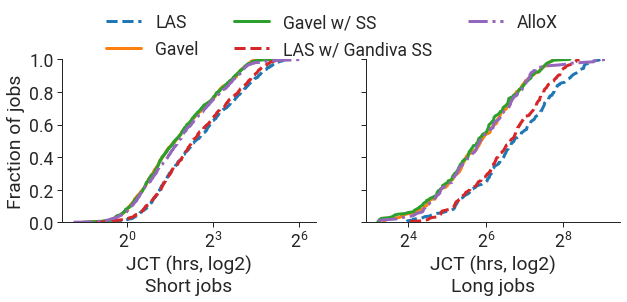

Input job rate: 5.20
max_min_fairness: 63.78
max_min_fairness_perf: 22.02
max_min_fairness_packed: 19.14
gandiva: 34.32
allox: 21.96


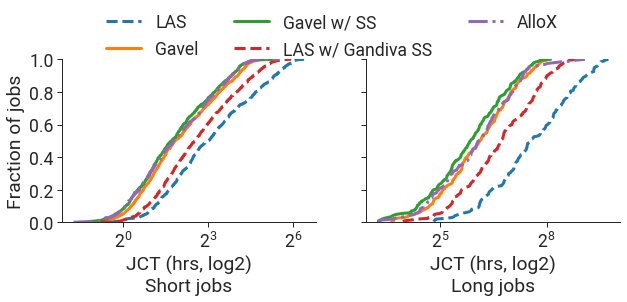

Input job rate: 5.60
max_min_fairness: 95.99
max_min_fairness_perf: 28.96
max_min_fairness_packed: 19.64
gandiva: 42.54
allox: 25.32


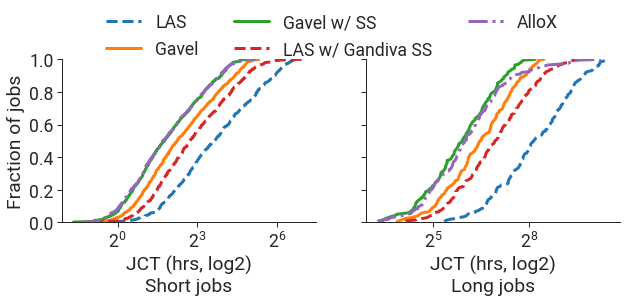

Input job rate: 6.00
max_min_fairness_perf: 41.23
max_min_fairness_packed: 20.42


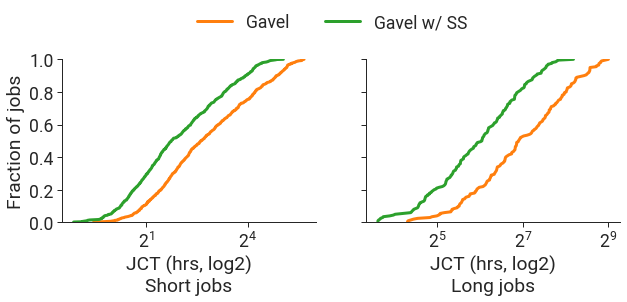

['finish_time_fairness', 'finish_time_fairness_perf', 'allox']
Input job rate: 0.40
finish_time_fairness: 23.26
finish_time_fairness_perf: 17.58
allox: 17.58


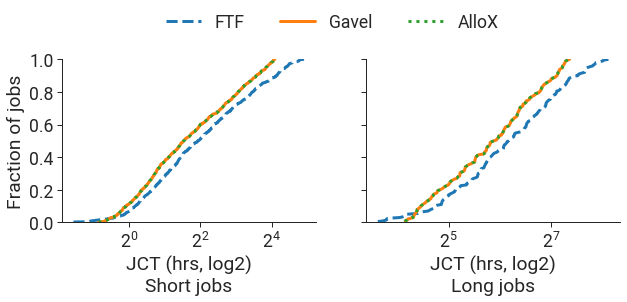

Input job rate: 0.80
finish_time_fairness: 23.33
finish_time_fairness_perf: 17.64
allox: 17.64


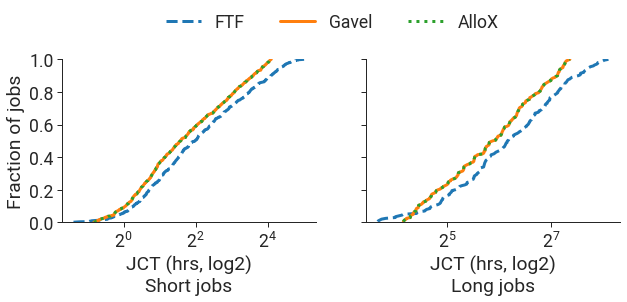

Input job rate: 1.20
finish_time_fairness: 23.51
finish_time_fairness_perf: 17.67
allox: 17.67


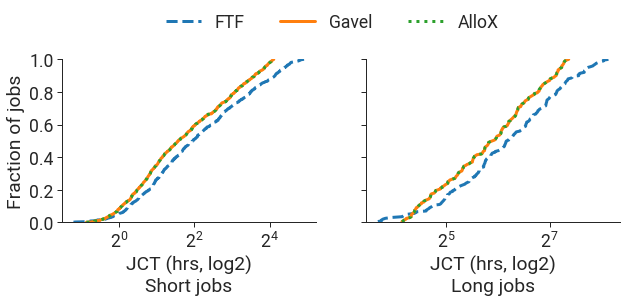

Input job rate: 1.60
finish_time_fairness: 23.58
finish_time_fairness_perf: 17.51
allox: 17.45


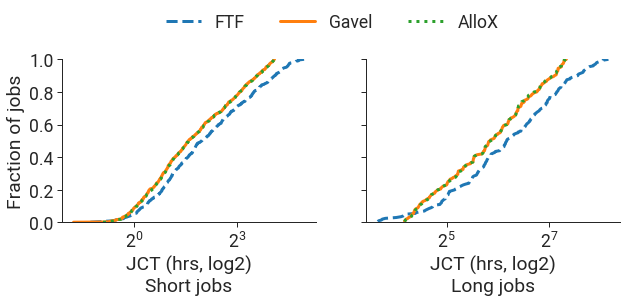

Input job rate: 2.00
finish_time_fairness: 23.47
finish_time_fairness_perf: 17.07
allox: 16.93


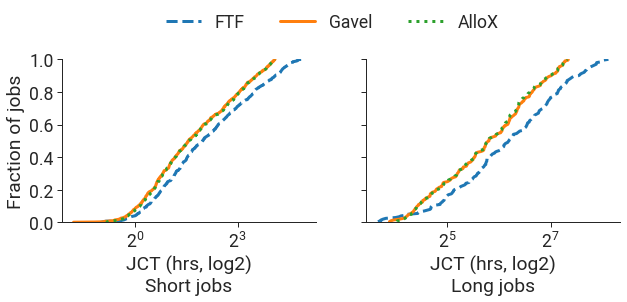

Input job rate: 2.40
finish_time_fairness: 23.38
finish_time_fairness_perf: 16.58
allox: 16.49


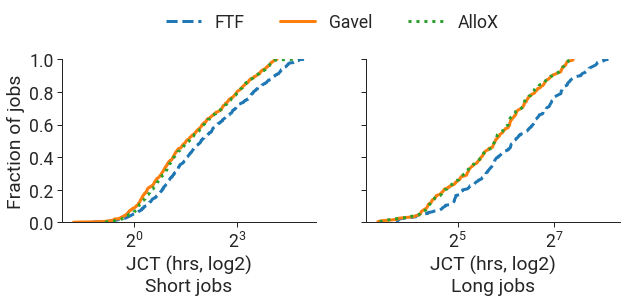

Input job rate: 2.80
finish_time_fairness: 23.51
finish_time_fairness_perf: 16.41
allox: 16.37


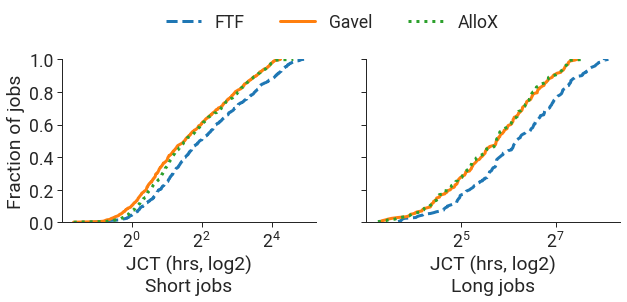

Input job rate: 3.20
finish_time_fairness: 23.58
finish_time_fairness_perf: 16.57
allox: 16.43


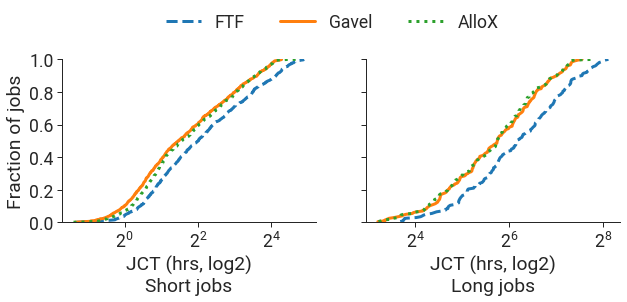

Input job rate: 3.60
finish_time_fairness: 23.50
finish_time_fairness_perf: 16.99
allox: 16.62


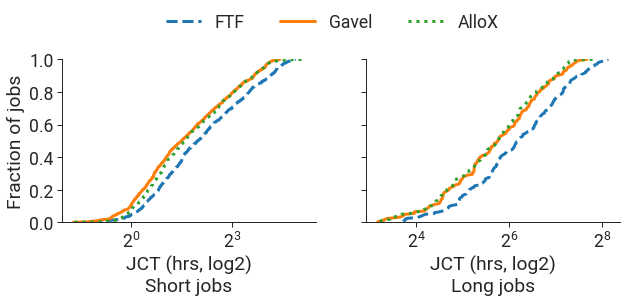

Input job rate: 4.00
finish_time_fairness: 23.43
finish_time_fairness_perf: 17.57
allox: 17.13


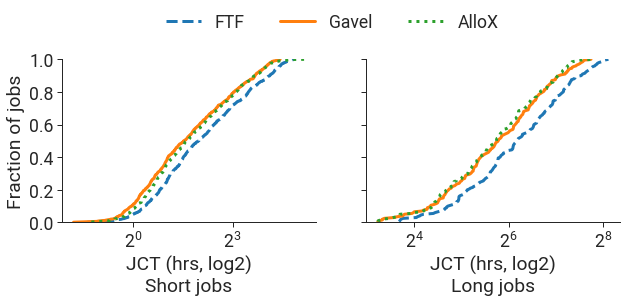

Input job rate: 4.40
finish_time_fairness: 23.75
finish_time_fairness_perf: 18.62
allox: 18.54


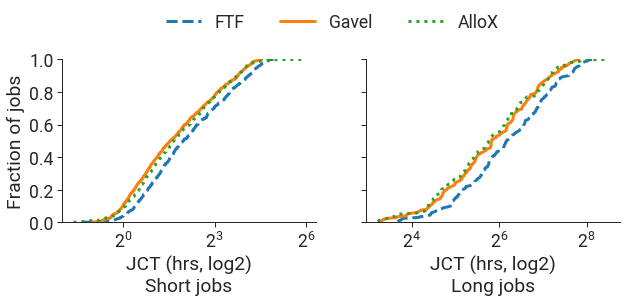

Input job rate: 4.80
finish_time_fairness: 34.93
finish_time_fairness_perf: 20.43
allox: 20.92


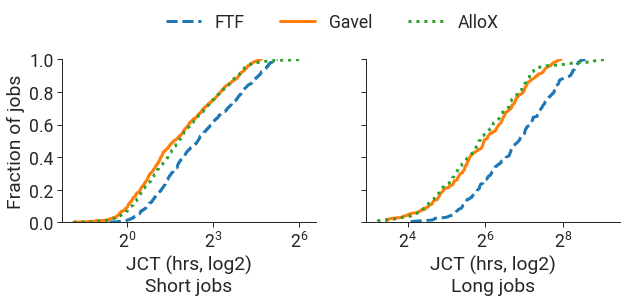

Input job rate: 5.20
finish_time_fairness: 64.46
finish_time_fairness_perf: 23.38
allox: 21.96


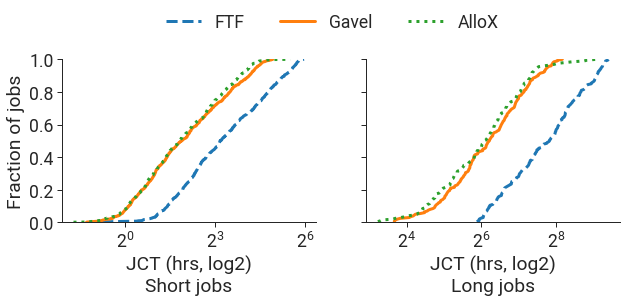

Input job rate: 5.60
finish_time_fairness: 85.54
finish_time_fairness_perf: 30.47
allox: 25.32


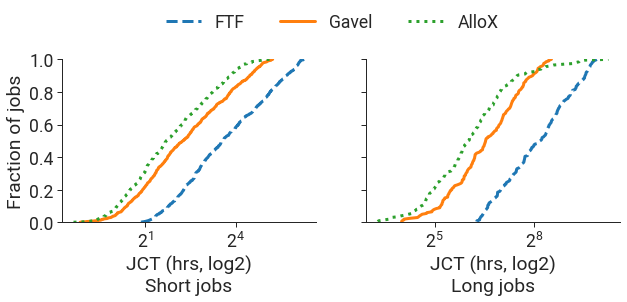

Input job rate: 6.00
finish_time_fairness: 109.14
finish_time_fairness_perf: 43.05


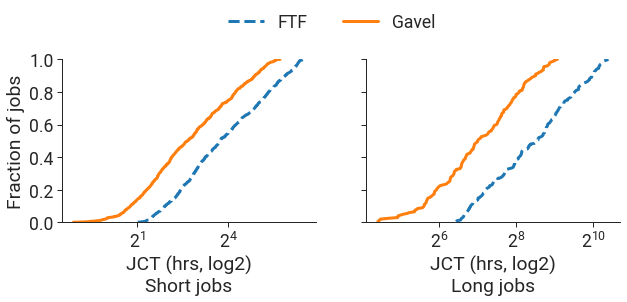

In [13]:
plot_jct_cdf(
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=6.0,
    policies=["fifo",
              "fifo_perf",
              "fifo_packed"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/single_gpu_fifo_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=6.0,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/single_gpu_las_without_allox_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=6.0,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva",
              "allox"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/single_gpu_las_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=6.0,
    policies=["finish_time_fairness",
              "finish_time_fairness_perf",
              "allox"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/single_gpu_ftf_v100=36_p100=36_k80=36/"
)

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva', 'allox']
Input job rate: 0.40
max_min_fairness: 1.00
max_min_fairness_perf: 0.84
max_min_fairness_packed: 0.89
gandiva: 0.84
allox: 0.84


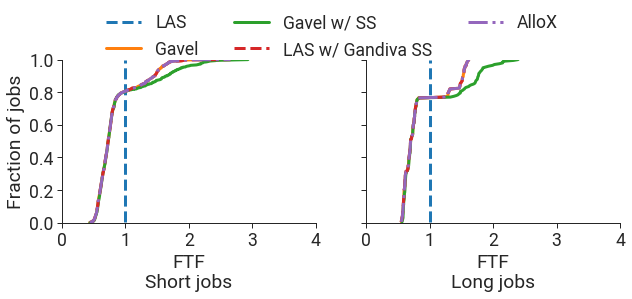

Input job rate: 0.80
max_min_fairness: 1.00
max_min_fairness_perf: 0.84
max_min_fairness_packed: 0.95
gandiva: 0.84
allox: 0.84


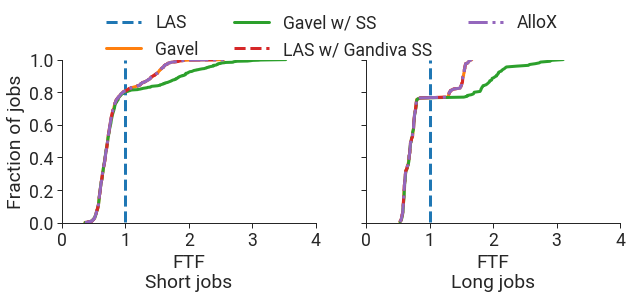

Input job rate: 1.20
max_min_fairness: 1.00
max_min_fairness_perf: 0.84
max_min_fairness_packed: 0.98
gandiva: 0.84
allox: 0.84


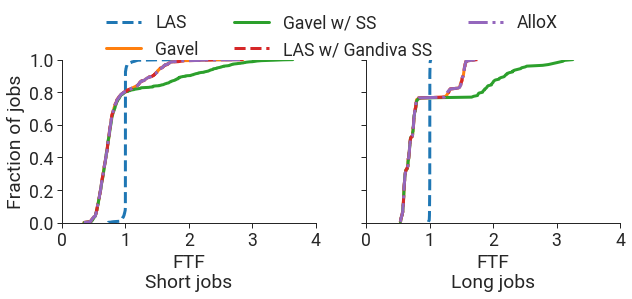

Input job rate: 1.60
max_min_fairness: 1.00
max_min_fairness_perf: 0.83
max_min_fairness_packed: 0.96
gandiva: 0.83
allox: 0.83


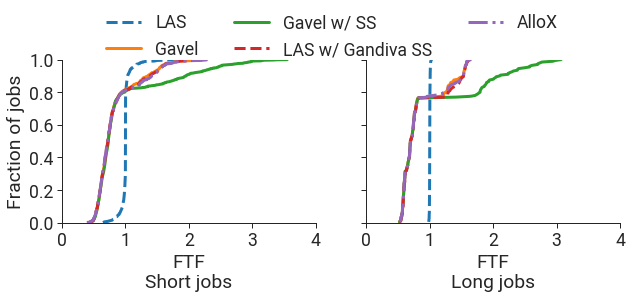

Input job rate: 2.00
max_min_fairness: 1.01
max_min_fairness_perf: 0.80
max_min_fairness_packed: 0.90
gandiva: 0.83
allox: 0.82


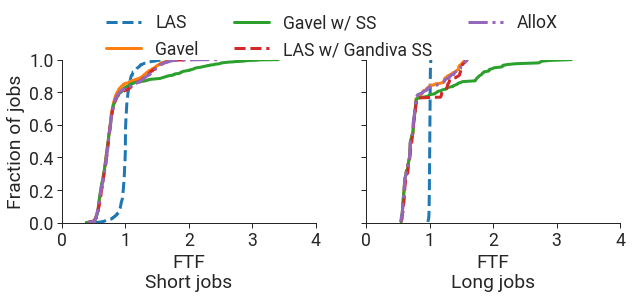

Input job rate: 2.40
max_min_fairness: 1.01
max_min_fairness_perf: 0.78
max_min_fairness_packed: 0.83
gandiva: 0.83
allox: 0.81


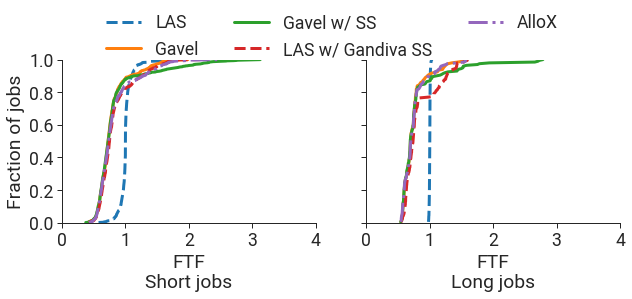

Input job rate: 2.80
max_min_fairness: 1.00
max_min_fairness_perf: 0.73
max_min_fairness_packed: 0.75
gandiva: 0.81
allox: 0.78


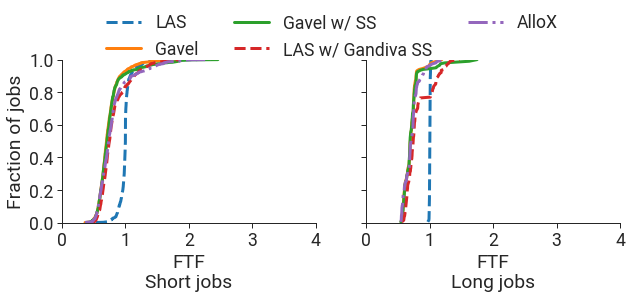

Input job rate: 3.20
max_min_fairness: 1.00
max_min_fairness_perf: 0.72
max_min_fairness_packed: 0.73
gandiva: 0.81
allox: 0.78


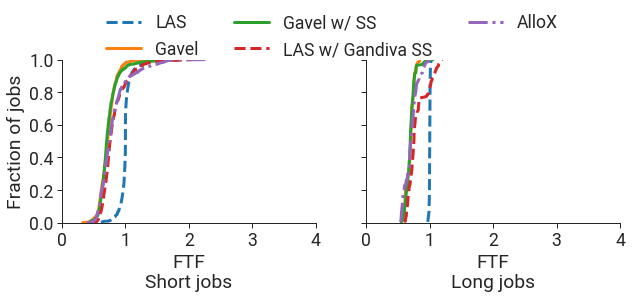

Input job rate: 3.60
max_min_fairness: 1.01
max_min_fairness_perf: 0.73
max_min_fairness_packed: 0.73
gandiva: 0.82
allox: 0.79


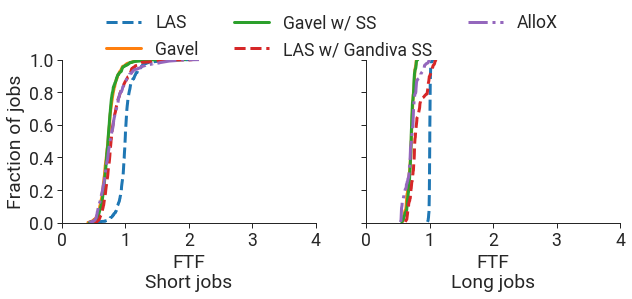

Input job rate: 4.00
max_min_fairness: 1.00
max_min_fairness_perf: 0.75
max_min_fairness_packed: 0.75
gandiva: 0.83
allox: 0.81


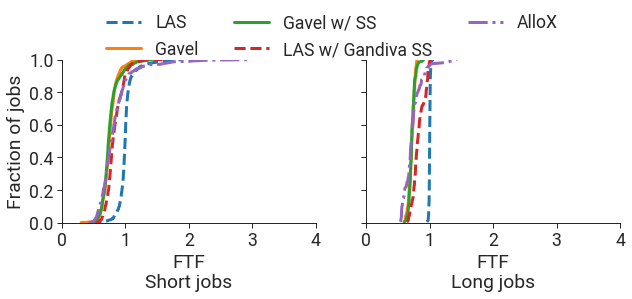

Input job rate: 4.40
max_min_fairness: 1.00
max_min_fairness_perf: 0.75
max_min_fairness_packed: 0.77
gandiva: 1.08
allox: 0.83


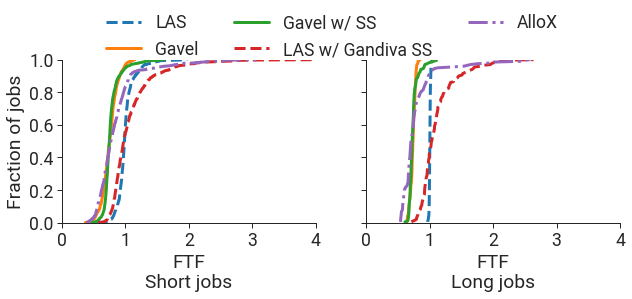

Input job rate: 4.80
max_min_fairness: 1.05
max_min_fairness_perf: 0.64
max_min_fairness_packed: 0.63
gandiva: 1.03
allox: 0.73


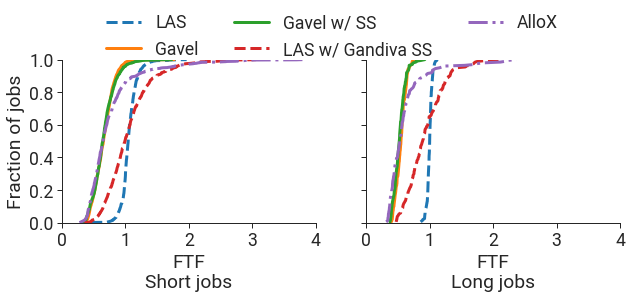

Input job rate: 5.20
max_min_fairness: 0.92
max_min_fairness_perf: 0.41
max_min_fairness_packed: 0.36
gandiva: 0.65
allox: 0.40


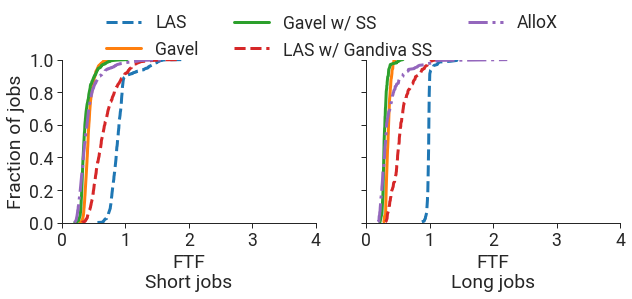

Input job rate: 5.60
max_min_fairness: 0.96
max_min_fairness_perf: 0.37
max_min_fairness_packed: 0.26
gandiva: 0.54
allox: 0.28


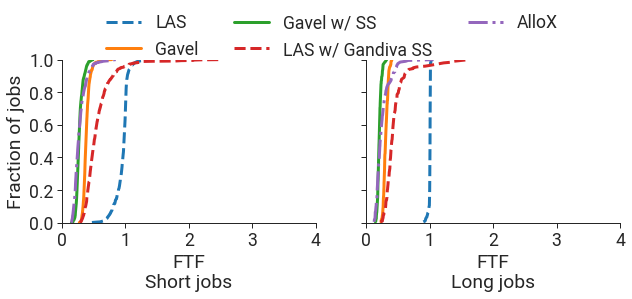

Input job rate: 6.00
['finish_time_fairness', 'finish_time_fairness_perf', 'allox']
Input job rate: 0.40
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.84
allox: 0.84


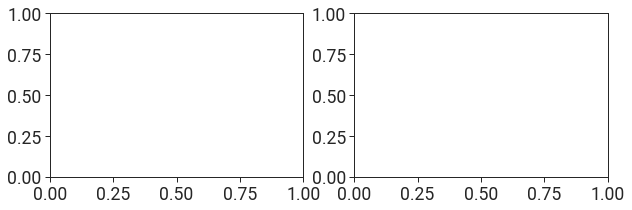

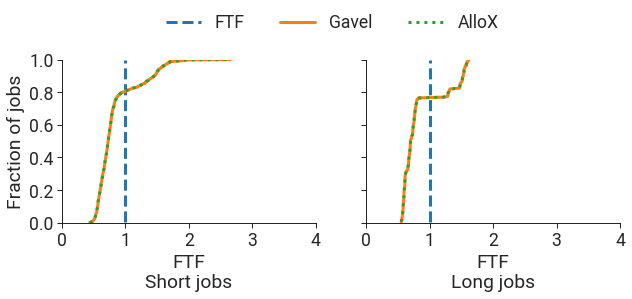

Input job rate: 0.80
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.84
allox: 0.84


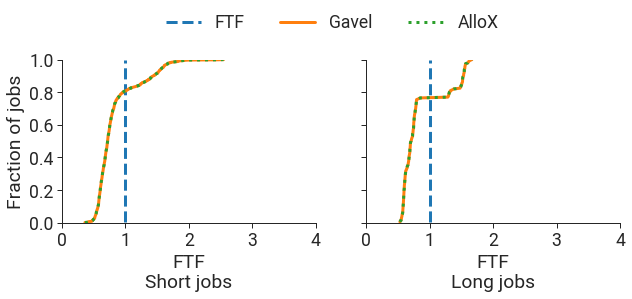

Input job rate: 1.20
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.84
allox: 0.84


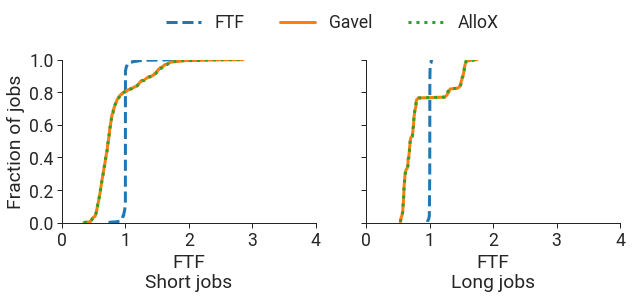

Input job rate: 1.60
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.82
allox: 0.83


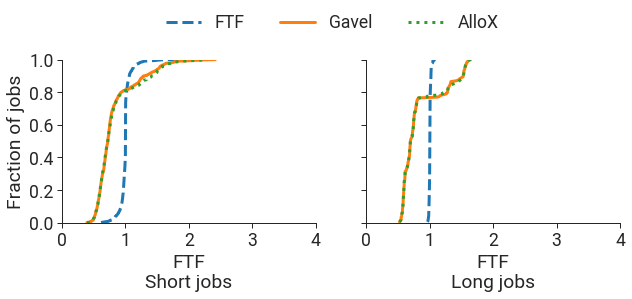

Input job rate: 2.00
finish_time_fairness: 1.01
finish_time_fairness_perf: 0.80
allox: 0.82


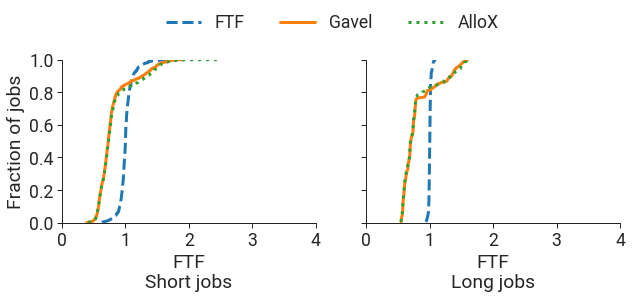

Input job rate: 2.40
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.77
allox: 0.81


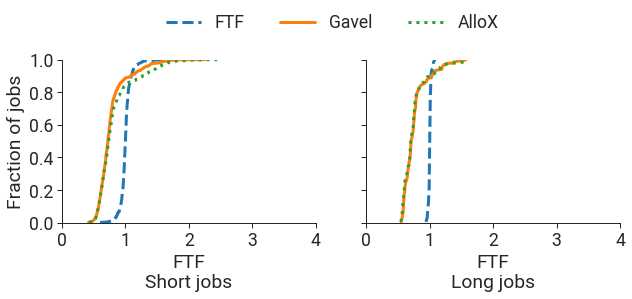

Input job rate: 2.80
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.73
allox: 0.78


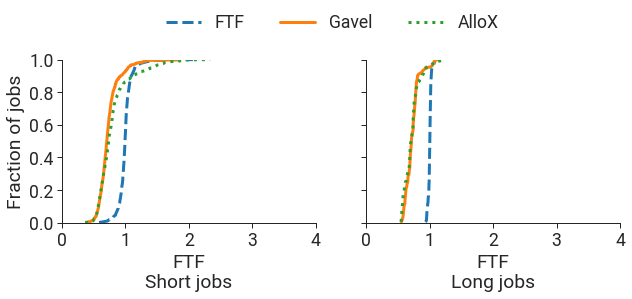

Input job rate: 3.20
finish_time_fairness: 1.01
finish_time_fairness_perf: 0.73
allox: 0.78


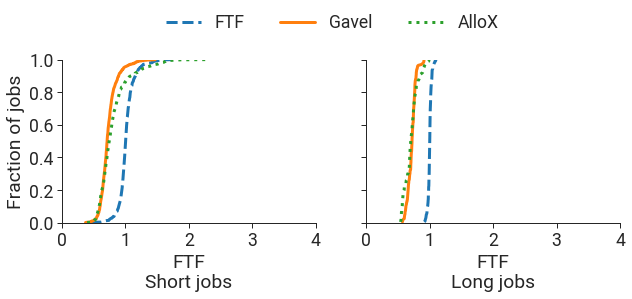

Input job rate: 3.60
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.73
allox: 0.79


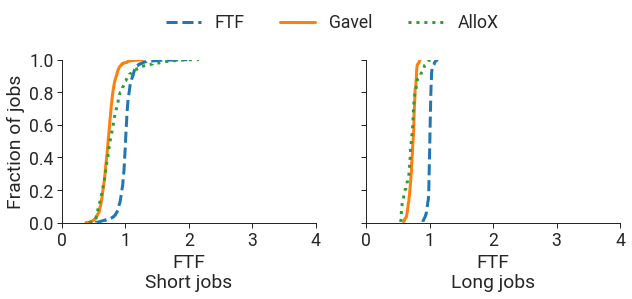

Input job rate: 4.00
finish_time_fairness: 1.01
finish_time_fairness_perf: 0.75
allox: 0.81


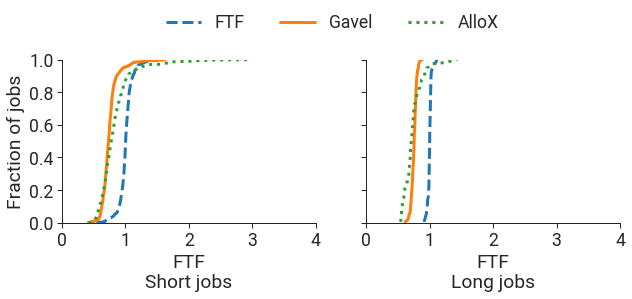

Input job rate: 4.40
finish_time_fairness: 1.01
finish_time_fairness_perf: 0.77
allox: 0.83


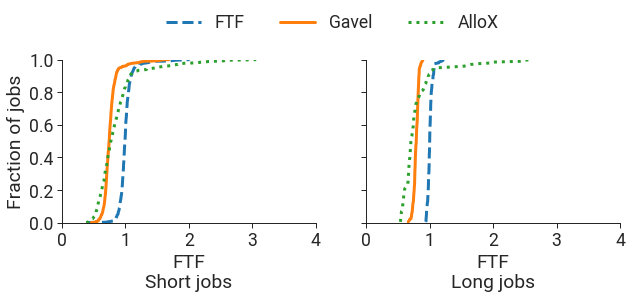

Input job rate: 4.80
finish_time_fairness: 1.09
finish_time_fairness_perf: 0.64
allox: 0.73


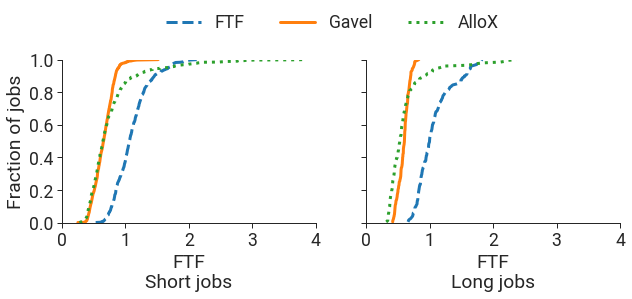

Input job rate: 5.20
finish_time_fairness: 1.07
finish_time_fairness_perf: 0.40
allox: 0.40


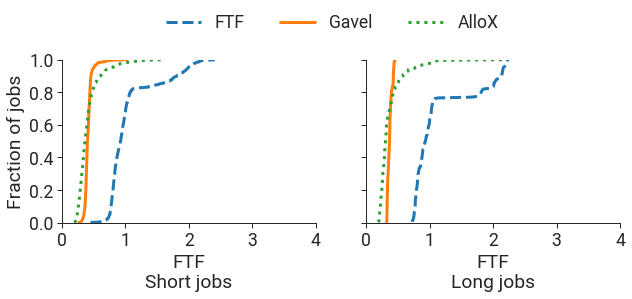

Input job rate: 5.60
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.36
allox: 0.28


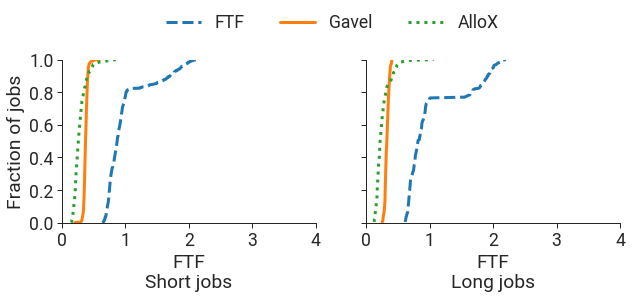

Input job rate: 6.00


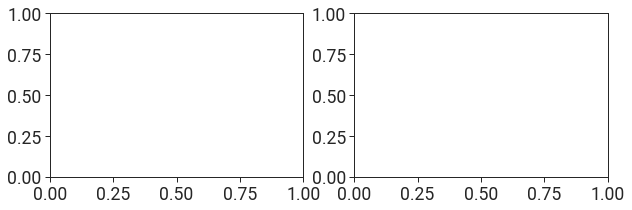

In [14]:
plot_jct_cdf(
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=6.0,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva",
              "allox"],
    min_job_id=4000, max_job_id=5000,
    finish_time_fairness=True,
    output_directory="continuous_jobs/ftf_cdf/single_gpu_las_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=6.0,
    policies=["finish_time_fairness",
              "finish_time_fairness_perf",
              "allox"],
    min_job_id=4000, max_job_id=5000,
    finish_time_fairness=True,
    output_directory="continuous_jobs/ftf_cdf/single_gpu_ftf_v100=36_p100=36_k80=36/"
)